# Gaussian Process

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.kernel_ridge import KernelRidge as KR

In [2]:
import warnings
warnings.simplefilter('ignore')

## Process the Datasetes

In [3]:
import pandas as pd
import git

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
datadir = f"{homedir}/data/us/"

df = pd.read_csv(datadir + 'covid/nyt_us_counties.csv')

In [4]:
df['date_processed'] = pd.to_datetime(df['date'].values)
df['date_processed'] = (df['date_processed'] - df['date_processed'].min()) / np.timedelta64(1, 'D')

In [6]:
df.head()

,date,county,state,fips,cases,deaths,date_processed
0,2020-01-21,Snohomish,Washington,53061.0,1,0,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0,1.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0,2.0
3,2020-01-24,Cook,Illinois,17031.0,1,0,3.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0,3.0


Fix the missing FIPS codes for some counties

In [7]:
# Manually set the FIPS codes for NYC and Guam as the data does 
# not have those set. 
df.loc[df['county'] == 'New York City', 'fips'] = 25017
df.loc[df['state'] == 'Guam', 'fips'] = 66010

# Remove areas with no FIPS codes.
df = df[df['fips'].isna() == False]

Great! Let's also make a helper function to select data from a region, starting when the pandemic hit to be able to fit models.

In [8]:
# return data ever since first min_cases cases
def select_region(df, fips, min_deaths=-1):
    d = df.loc[df['fips'] == fips]
    deaths = np.where(d['deaths'].values > min_deaths)[0]
    if len(deaths) == 0:
        return []
    start = deaths[0]
    d = d[start:]
    return d

In [9]:
import utils2 as utils
df = utils.get_processed_df()
print(df.head)

<bound method NDFrame.head of               date      county       state     fips  cases  deaths  \
0       2020-01-21   Snohomish  Washington  53061.0      1       0   
1       2020-01-22   Snohomish  Washington  53061.0      1       0   
2       2020-01-23   Snohomish  Washington  53061.0      1       0   
3       2020-01-24        Cook    Illinois  17031.0      1       0   
4       2020-01-24   Snohomish  Washington  53061.0      1       0   
...            ...         ...         ...      ...    ...     ...   
129742  2020-05-09    Sublette     Wyoming  56035.0      3       0   
129743  2020-05-09  Sweetwater     Wyoming  56037.0     19       0   
129744  2020-05-09       Teton     Wyoming  56039.0     98       1   
129745  2020-05-09       Uinta     Wyoming  56041.0      9       0   
129746  2020-05-09    Washakie     Wyoming  56043.0      7       0   

        date_processed  
0                  0.0  
1                  1.0  
2                  2.0  
3                  3.0  
4   

In [10]:
import pymc3 as pm
import arviz as az

## Gaussian Process with Erf prior

In [11]:
import erf_model_small_changes as em

In [12]:
out_fips, all_row_starts = utils.all_output_fips('sample_submission.csv')
print(len(out_fips))

3223


In [13]:
county_fips = 36061
d = select_region(df, county_fips)
print(d == [])
if np.max(d['deaths']) == 0:
    result = np.zeroes((num_days, 9))
print(d.tail)

ValueError: Unable to coerce to Series, length must be 7: given 0

In [14]:
import theano.tensor as tt

class Erf(pm.gp.mean.Mean):
    def __init__(self, fit_func, params):
        # Erf.__init__(self)
        self.fit_func = fit_func
        self.params = params

    def __call__(self, X):
        X = X.reshape(1, -1)[0]
        return em.run_model(self.fit_func, self.params, X)

In [15]:

with pm.Model() as gp_covid_model:
    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)

    fit_func, popt, pcov, X_train, y_train, X_pred = em.fit_erf(df, county_fips)
    print(popt)
    print(y_train)
#     errors = np.sqrt(np.diag(pcov))
#     print(errors)
    # X_pred = X_pred[X_pred >= X_train[0]]

    # Set the Erf prior
    M = Erf(fit_func, popt)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ)

    σ = pm.HalfNormal('σ', 50)

    covid_deaths_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    covid_deaths_gp.marginal_likelihood('covid_deaths', X=X_train.reshape(-1, 1), 
                           y=y_train, noise=σ)

[4.28609703e+00 6.57564865e-02 8.33332038e+01]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     1     5     7    11    25    31    54    75   119   155   230
   330   435   560   825   991  1202  1475  1848  2152  2648  3221  3646
  4857  5631  6441  7249  7981  8734  9448 10096 10857 11566 12109 12283
 12411 13632 14074 14513 14959 15361 15754 16146 16486 16821 17206 17597
 17809 17931 18021 18451 18580 18719 18993 19141 19210 19324]


In [16]:
# tune = 2000, random_seed=42
if len(popt) == 2:
    with gp_covid_model:
        gp_trace = pm.sample(100, tune=100, cores=2, random_seed=10)
else:
    with gp_covid_model:
        gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:38<00:00, 157.33draws/s]


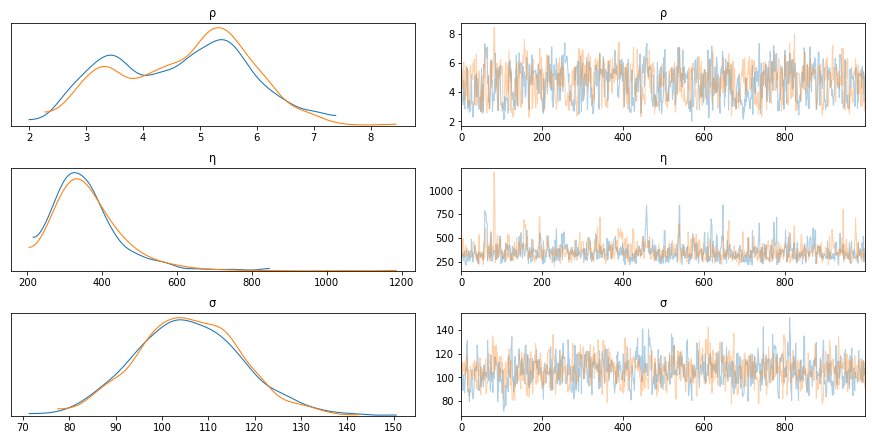

In [17]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [18]:
with gp_covid_model:
    covid_pred = covid_deaths_gp.conditional("covid_pred", X_pred.reshape(-1, 1))
    gp_covid_samples = pm.sample_posterior_predictive(gp_trace, vars=[covid_pred], samples=3, random_seed=42)

100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


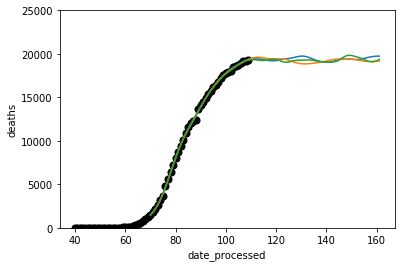

In [19]:
ax = d.plot.scatter(x='date_processed', y='deaths', c='k', s=50)
ax.set_ylim(0, 25000)
for x in gp_covid_samples['covid_pred']:
    ax.plot(X_pred, x)

In [20]:
with gp_covid_model:
    gp_covid_samples = pm.sample_posterior_predictive(gp_trace, vars=[covid_pred], samples=100, random_seed=42)

100%|██████████| 100/100 [00:00<00:00, 107.29it/s]


(0, 25000)

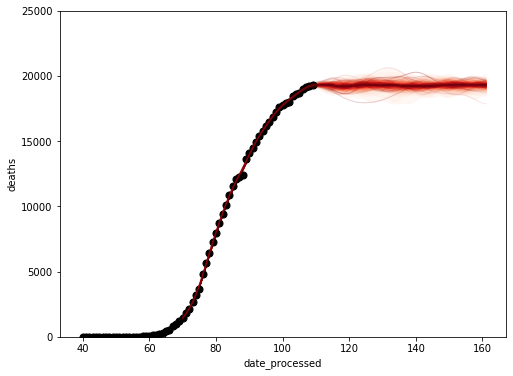

In [21]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_covid_samples['covid_pred'], X_pred)
d.plot.scatter(x='date_processed', y='deaths', c='k', s=50, ax=ax)
ax.set_ylim(0, 25000)

In [22]:
with gp_covid_model:
    covid_pred_noise = covid_deaths_gp.conditional("covid_pred_noise", X_pred.reshape(-1,1), pred_noise=True)
    gp_covid_samples = pm.sample_posterior_predictive(gp_trace, vars=[covid_pred_noise], samples=500, random_seed=42)

100%|██████████| 500/500 [00:04<00:00, 118.50it/s]


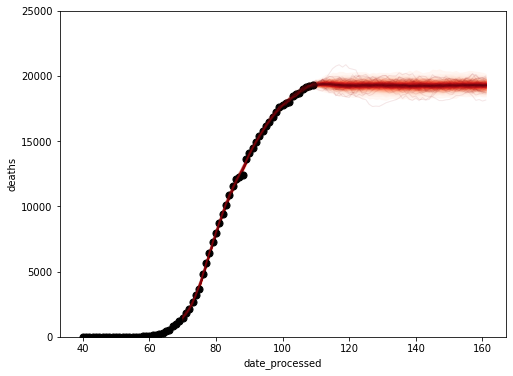

In [23]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_covid_samples['covid_pred_noise'], X_pred)
d.plot.scatter(x='date_processed', y='deaths', c='k', s=50, ax=ax)
ax.set_ylim(0, 25000);

In [177]:
print(np.diff(gp_covid_samples['covid_pred_noise'][1]))
print(np.diff(gp_covid_samples['covid_pred_noise'])[1])
# print(np.percentile(gp_covid_samples['covid_pred_noise'], 90, axis=0))

[  242.9536026    240.50850061   412.08389126    58.36130475
   438.48208559  1027.5357478    473.2006625    494.08620251
   674.32496411   658.91986358   206.26881441   638.57276819
   370.59892761   577.79331921   614.34187969   393.67931462
   -12.64618063  -190.41341631  1317.92604908   188.08508554
   329.27383219   281.97877201   374.86498797   400.87461894
   -86.77739107   339.23669801    44.46850408   460.92432674
   202.81558888   338.40391609   109.70441502    71.10318131
   255.65307704   130.46866068   204.83925847  5539.1013614
   424.6071406  -2263.95601961  -754.31223717  1173.80688995
  1332.15570733 -1236.05306655 -1158.16705509   663.49812226
   976.93312492  -176.50313853  -486.66549679   524.44720012
   390.69521578    85.16694154   382.46990061  -303.07377194
 -1105.93242431   215.63535151  1365.12717409  -844.54800779
  -641.93549059  1379.66528158  -142.54951518  -876.80133613
   240.23682159   463.49123632   467.84015187   843.37910447
    93.3041562   -462.471